# Fine-Tuning Bert

In [1]:
!pip install hazm

  Obtaining dependency information for hazm from https://files.pythonhosted.org/packages/6a/06/302d69a49f0ea8d5700341fcd5f0630361fe7d8cf17254ff45702ecf6058/hazm-0.9.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 17.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 67.6 MB/s eta 0:00:00
  Obtaining dependency information for python-crfsuite<0.10.0,>=0.9.9 from https://files.pythonhosted.org/packages/38/1d/c475ba7d11e9735f00eb08e2f5315aa2e21c24cc85a0474c3fd425edef58/python_crfsuite-0.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.9 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into ac

## Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import json
import collections

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset, load_metric, DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import hazm


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
seed_val = 42

## Setting Up the GPU

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Load the dataset

In [5]:
def create_dataframe(csv_path):
    df = pd.read_csv(csv_path, sep='\t')
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [6]:
train_csv_path = '/kaggle/input/farstail/Train-word.csv'
test_csv_path = '/kaggle/input/farstail/Test-word.csv'
val_csv_path = '/kaggle/input/farstail/Val-word.csv'

In [7]:
train_df = create_dataframe(train_csv_path)
test_df = create_dataframe(test_csv_path)
val_df = create_dataframe(val_csv_path)

In [8]:
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(train_df)
dataset['test'] = Dataset.from_pandas(test_df)
dataset['val'] = Dataset.from_pandas(val_df)

In [9]:
train_df.head()

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7266 entries, 0 to 7265
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     7266 non-null   object
 1   hypothesis  7266 non-null   object
 2   label       7266 non-null   object
dtypes: object(3)
memory usage: 170.4+ KB


In [11]:
train_df.describe()

,premise,hypothesis,label
count,7266,7266,7266
unique,2468,7258,3
top,قرآن دارای ۱۱۴ سوره و سی جزء و ۱۲۰ حزب و ۶۲۳۶ ...,امام راحل فرمودند: این دست امریکاست که از آستی...,n
freq,6,2,2448


In [12]:
train_df.shape

(7266, 3)

<Axes: xlabel='label'>

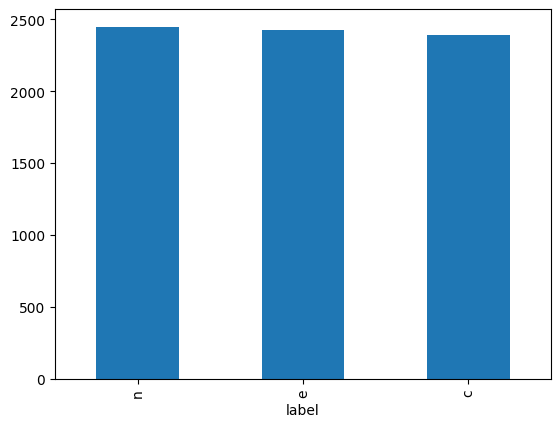

In [13]:
train_df['label'].value_counts().plot(kind='bar')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


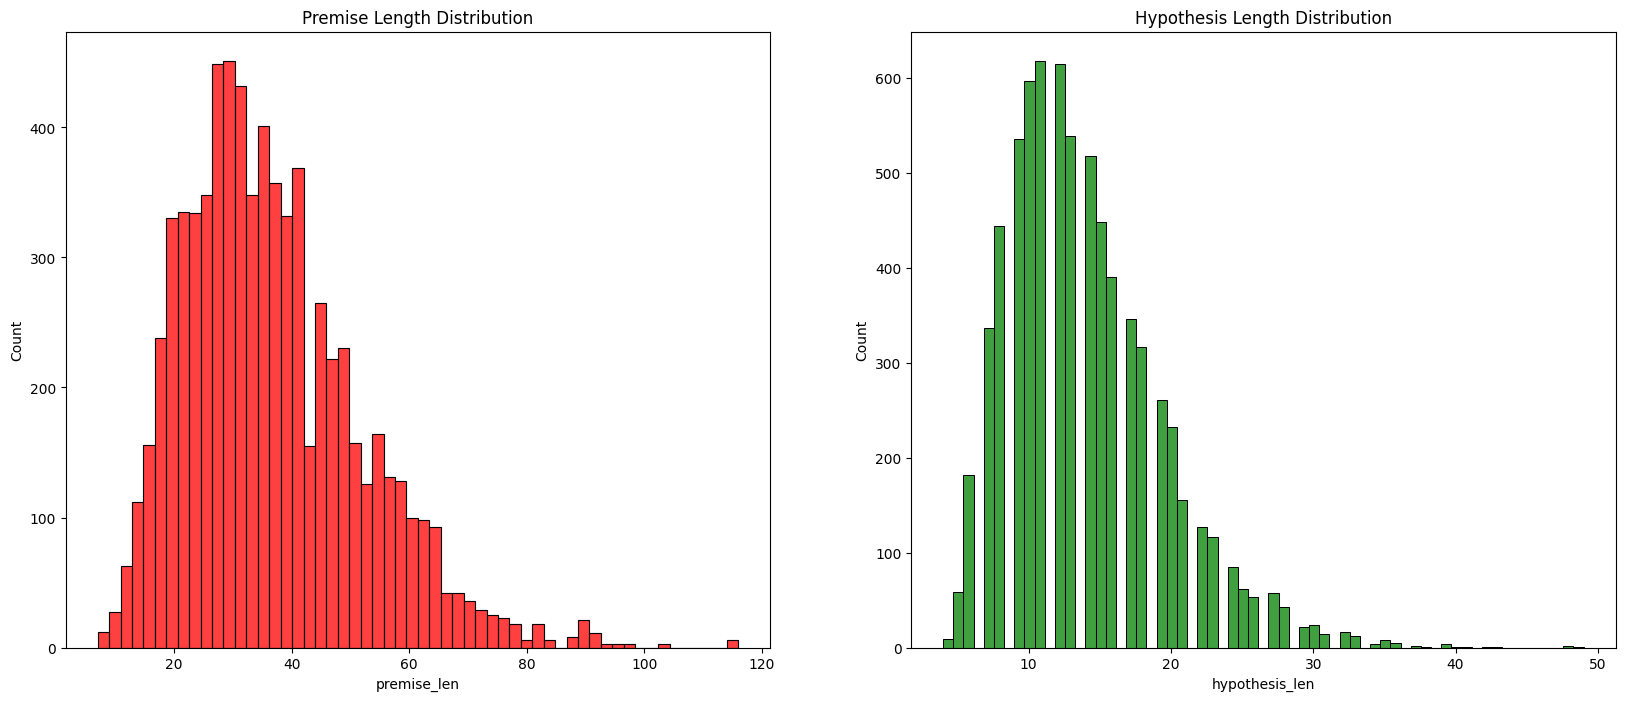

In [14]:
train_df['premise_len'] = train_df['premise'].apply(lambda x: len(x.split()))
train_df['hypothesis_len'] = train_df['hypothesis'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(train_df['premise_len'], ax=ax[0], color='red')
sns.histplot(train_df['hypothesis_len'], ax=ax[1], color='green')
ax[0].set_title('Premise Length Distribution')
ax[1].set_title('Hypothesis Length Distribution')
plt.show()


## Preprocessing the dataset

In [15]:
class FarsTailTokenizer:
    def __init__(self, model_name, max_length, loading_batch_size=1000, stride=128):
        self.model_name = model_name
        self.max_length = max_length
        self.loading_batch_size = loading_batch_size
        self.stride = stride
        self.label_mapping = {'e': [1, 0, 0], 'n': [0, 1, 0], 'c': [0, 0, 1]}
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.word_tokenizer = hazm.WordTokenizer()
        self.normalizer = hazm.Normalizer()
        self.stemmer = hazm.Stemmer()
        self.lemmatizer = hazm.Lemmatizer()
        self.stopwords = hazm.stopwords_list()

    def tokenize(self, dataset):    
        tokenized_batches = []
        for i in tqdm(range(0, len(dataset), self.loading_batch_size)):
            batch = dataset[i:i+self.loading_batch_size]
            tokenized_batch = self.batch_tokenize(batch)
            tokenized_batches.extend(tokenized_batch)

        return tokenized_batches


    def batch_tokenize(self, batch):
        premise = batch['premise']
        hypothesis = batch['hypothesis']

        premise = [self.normalizer.normalize(text) for text in premise]
        hypothesis = [self.normalizer.normalize(text) for text in hypothesis]

        tokenized_batch = self.tokenizer(
            premise,
            hypothesis,
            padding='max_length',
            truncation='only_first',
            max_length=self.max_length,
            return_tensors='pt',
            stride=self.stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
        )

        tokenized_batch['premise'] = premise
        tokenized_batch['hypothesis'] = hypothesis
        tokenized_batch['label'] = [self.label_mapping[label] for label in batch['label']]

        # print(f'premise                 : shape={len(tokenized_batch["premise"])}\n{tokenized_batch["premise"][0]}')
        # print(f'hypothesis              : shape={len(tokenized_batch["hypothesis"])}\n{tokenized_batch["hypothesis"][0]}')
        # print(f'input_ids               : shape={tokenized_batch["input_ids"].shape}\n{tokenized_batch["input_ids"][0]}')
        # print(f'attention_mask          : shape={tokenized_batch["attention_mask"].shape}\n{tokenized_batch["attention_mask"][0]}')
        # print(f'token_type_ids          : shape={tokenized_batch["token_type_ids"].shape}\n{tokenized_batch["token_type_ids"][0]}')
        # print(f'offset_mapping          : shape={tokenized_batch["offset_mapping"].shape}\n{tokenized_batch["offset_mapping"][0]}')
        # print(f'label                   : shape={len(tokenized_batch["label"])}\n{tokenized_batch["label"][0]}')
        # print('---------------------------------------------------')

        tokenized_batch = [dict(zip(tokenized_batch, t)) for t in zip(*tokenized_batch.values())]

        return tokenized_batch
    

In [16]:
class FarsTailDataset(Dataset):
    def __init__(self, dataset, model_name, max_length, loading_batch_size=1000, stride=128): 
        self.dataset = dataset
        self.tokenizer = FarsTailTokenizer(model_name, max_length, loading_batch_size, stride)
        self.tokenized_dataset = self.tokenizer.tokenize(dataset)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.tokenized_dataset[idx]
        

In [17]:
model_name = 'HooshvareLab/bert-base-parsbert-uncased'
train_dataset = FarsTailDataset(dataset['train'], model_name, 128, 1000, 32)
test_dataset = FarsTailDataset(dataset['test'], model_name, 128, 1000, 32)
val_dataset = FarsTailDataset(dataset['val'], model_name, 128, 1000, 32)

config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


In [18]:
train_dataset[0]

{'input_ids': tensor([    2,  3001,  3485,   331,  5021,  3673,  3251,   331,  8367,  2471,
          2031,  3509,  2036,  2903,  9827,  8575,  5188,   300, 40431,   331,
         35569,  2357,  2527,   331,  3648,  4228,  2031,  3199,  2042,  3485,
          3686, 11849, 11481, 21235,  2083,    15,     4,  3633,  3485,   331,
          5021,  3673,  3251,   331,  8367,  2471,  2031,  3509,  2036,  2903,
          9827,  8575,  5188,   300, 40431,   331, 35569,  2083,   331, 11481,
         21235,  4228,  2042,  3199,  2049,  4407,  2299,    15,     4,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [19]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

## Implementing the models

### loss and accuracy plots during training

In [20]:
def plot_training_summary(title, loss_vals, accuracy_vals, epochs):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title + " loss")

    plt.subplot(1, 2, 2)
    plt.plot(np.linspace(1, epochs, epochs).astype(int), accuracy_vals)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(title + " accuracy")

    plt.tight_layout()
    plt.show()

### Training loop

In [21]:
def train_classifier(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=1):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        print(f'---------- Epoch {epoch+1}/{num_epochs} ----------')
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            label = batch["label"]
            label = torch.stack(label).transpose(0, 1)
            label = label.to(device)
            label = label.float()

            outputs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred_labels = torch.sigmoid(outputs)
            pred_labels = torch.round(pred_labels)
            train_acc += (pred_labels == label).sum().item()
            # train_acc += (outputs.argmax(1) == label).sum().item()

        train_loss /= len(train_dataloader.dataset) * 3
        train_acc /= len(train_dataloader.dataset) * 3

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for batch in tqdm(test_dataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                label = batch["label"]
                label = torch.stack(label).transpose(0, 1)
                label = label.to(device)
                label = label.float()

                outputs = model(input_ids, attention_mask, token_type_ids)
                loss = criterion(outputs, label)

                test_loss += loss.item()
                pred_labels = torch.sigmoid(outputs)
                pred_labels = torch.round(pred_labels)
                test_acc += (pred_labels == label).sum().item()
                # test_acc += (outputs.argmax(1) == label).sum().item()

        test_loss /= len(test_dataloader.dataset)
        test_acc /= len(test_dataloader.dataset) * 3

        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training loss: {train_loss:.4f} | Training accuracy: {train_acc:.4f}')
        print(f'Testing loss: {test_loss:.4f} | Testing accuracy: {test_acc:.4f}')
        print()

    return train_losses, train_accs, test_losses, test_accs

### Evaluation loop

In [22]:
def evaluate_classifier(model, dataloader, criterion):
    model.eval()
    actual_label_inverse_mapping = {(1, 0, 0): 'e', (0, 1, 0): 'n', (0, 0, 1): 'c'}
    predicted_label_inverse_mapping = {0: 'e', 1: 'n', 2: 'c'}
    predictions = []
    actual_labels = []
    loss = 0
    acc = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            label = batch["label"]
            label = torch.stack(label).transpose(0, 1)
            label = label.to(device)
            label = label.float()

            outputs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, label)

            loss += loss.item()
            pred_labels = torch.sigmoid(outputs)
            pred_labels = torch.argmax(pred_labels, dim=1)

            batch_actual_labels = [actual_label_inverse_mapping[tuple(l.tolist())] for l in label]
            batch_predicted_labels = [predicted_label_inverse_mapping[l.item()] for l in pred_labels]
        
            actual_labels.extend(batch_actual_labels)
            predictions.extend(batch_predicted_labels)

            acc += sum([1 if l == p else 0 for l, p in zip(batch_actual_labels, batch_predicted_labels)])

    loss /= len(dataloader.dataset)
    acc /= len(dataloader.dataset)

    print(f'Loss: {loss:.4f} | Accuracy: {acc:.4f}')

    return loss, acc, actual_labels, predictions

### Evaluation Metrics

In [23]:
def calculate_metrics(actual_labels, predictions):
    print(classification_report(actual_labels, predictions))
    cm = confusion_matrix(actual_labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

### Model Architecture

In [24]:
class BaseLineModel(nn.Module):
    def __init__(self, model_name, num_classes, num_layers_to_keep=12):
        super(BaseLineModel, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.config.num_labels = num_classes
        self.config.num_hidden_layers = num_layers_to_keep
        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

### Fine-Tuning Bert Without Freezing Any Layers

In [25]:
baseline_model = BaseLineModel(model_name, 3)
baseline_model.to(device)
baseline_model

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

BaseLineModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseline_model.parameters(), lr=2e-5)
num_epochs = 10

baseline_train_losses, baseline_train_accs, baseline_test_losses, baseline_test_accs = train_classifier(baseline_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

---------- Epoch 1/10 ----------


100%|██████████| 24/24 [00:10<00:00,  2.29it/s]


Epoch 1/10:
Training loss: 0.0054 | Training accuracy: 0.6392
Testing loss: 0.0128 | Testing accuracy: 0.7350

---------- Epoch 2/10 ----------


100%|██████████| 24/24 [00:10<00:00,  2.28it/s]


Epoch 2/10:
Training loss: 0.0047 | Training accuracy: 0.7036
Testing loss: 0.0108 | Testing accuracy: 0.8120

---------- Epoch 3/10 ----------


100%|██████████| 24/24 [00:10<00:00,  2.29it/s]


Epoch 3/10:
Training loss: 0.0037 | Training accuracy: 0.7690
Testing loss: 0.0117 | Testing accuracy: 0.7849

---------- Epoch 4/10 ----------


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


Epoch 4/10:
Training loss: 0.0027 | Training accuracy: 0.8243
Testing loss: 0.0125 | Testing accuracy: 0.7549

---------- Epoch 5/10 ----------


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


Epoch 5/10:
Training loss: 0.0018 | Training accuracy: 0.8660
Testing loss: 0.0136 | Testing accuracy: 0.7677

---------- Epoch 6/10 ----------


100%|██████████| 24/24 [00:10<00:00,  2.29it/s]


Epoch 6/10:
Training loss: 0.0011 | Training accuracy: 0.9060
Testing loss: 0.0158 | Testing accuracy: 0.7523

---------- Epoch 7/10 ----------


100%|██████████| 24/24 [00:10<00:00,  2.28it/s]


Epoch 7/10:
Training loss: 0.0008 | Training accuracy: 0.9262
Testing loss: 0.0166 | Testing accuracy: 0.7573

---------- Epoch 8/10 ----------


100%|██████████| 24/24 [00:10<00:00,  2.26it/s]


Epoch 8/10:
Training loss: 0.0005 | Training accuracy: 0.9438
Testing loss: 0.0232 | Testing accuracy: 0.7350

---------- Epoch 9/10 ----------


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


Epoch 9/10:
Training loss: 0.0004 | Training accuracy: 0.9496
Testing loss: 0.0220 | Testing accuracy: 0.7504

---------- Epoch 10/10 ----------


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]

Epoch 10/10:
Training loss: 0.0004 | Training accuracy: 0.9535
Testing loss: 0.0195 | Testing accuracy: 0.7608



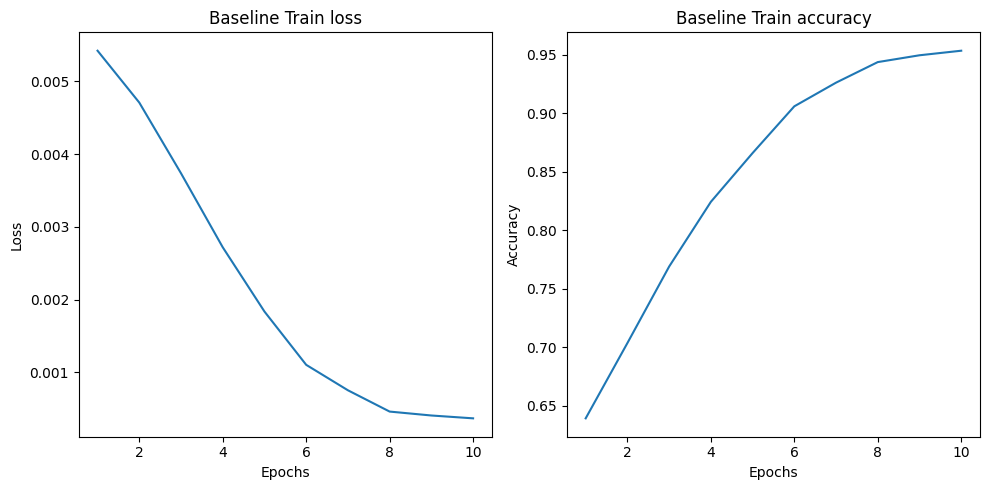

In [27]:
plot_training_summary('Baseline Train', baseline_train_losses, baseline_train_accs, num_epochs)

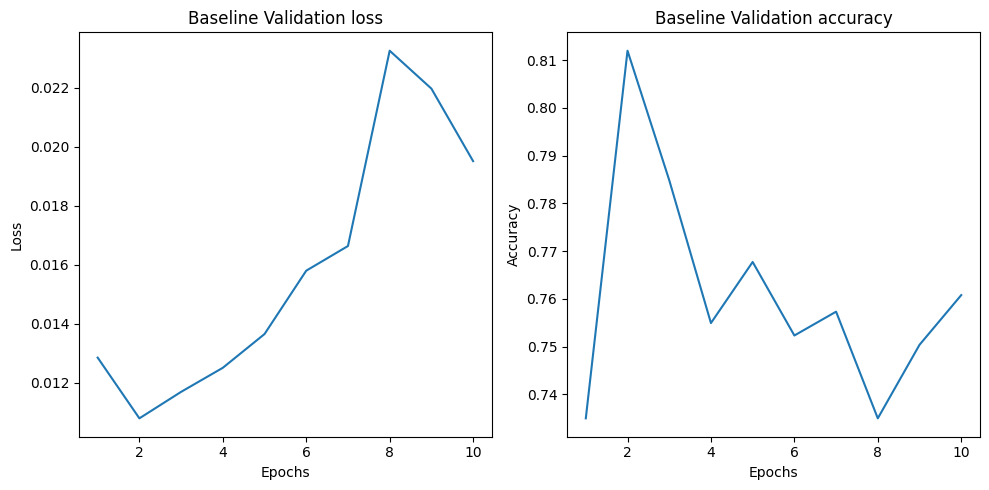

In [28]:
plot_training_summary('Baseline Validation', baseline_test_losses, baseline_test_accs, num_epochs)

In [29]:
baseline_loss, baseline_acc, baseline_actual_labels, baseline_predictions = evaluate_classifier(baseline_model, test_dataloader, criterion)

100%|██████████| 24/24 [00:10<00:00,  2.27it/s]

Loss: 0.0017 | Accuracy: 0.6432


              precision    recall  f1-score   support

           c       0.62      0.56      0.59       501
           e       0.67      0.69      0.68       510
           n       0.68      0.71      0.69       525

    accuracy                           0.65      1536
   macro avg       0.65      0.65      0.65      1536
weighted avg       0.65      0.65      0.65      1536



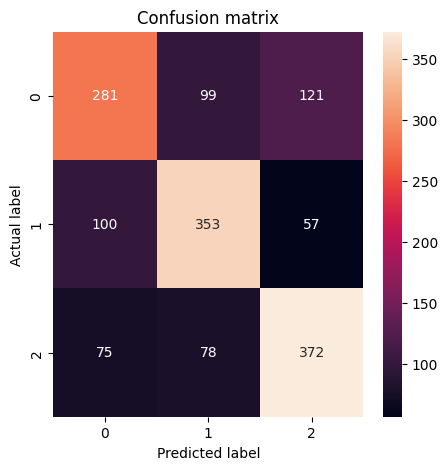

In [30]:
calculate_metrics(baseline_actual_labels, baseline_predictions)

### Fine-Tuning BERT With Freezing First 9 Layers

In [31]:
model_freezed_first_9_layers = BaseLineModel(model_name, 3)
model_freezed_first_9_layers.to(device)
model_freezed_first_9_layers

BaseLineModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [32]:
for param in model_freezed_first_9_layers.bert.embeddings.parameters():
    param.requires_grad = False
for i in range(0, 9):
    for param in model_freezed_first_9_layers.bert.encoder.layer[i].parameters():
        param.requires_grad = False
        
total_params = sum(p.numel() for p in model_freezed_first_9_layers.parameters())
trainable_params = sum(p.numel() for p in model_freezed_first_9_layers.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}, Trainable parameters: {trainable_params}')

Total parameters: 162843651, Trainable parameters: 21856515


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_freezed_first_9_layers.parameters(), lr=2e-5)
num_epochs = 5

freezed_first_9_layers_train_losses, freezed_first_9_layers_train_accs, freezed_first_9_layers_test_losses, freezed_first_9_layers_test_accs = train_classifier(model_freezed_first_9_layers, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

---------- Epoch 1/5 ----------


100%|██████████| 24/24 [00:10<00:00,  2.28it/s]


Epoch 1/5:
Training loss: 0.0056 | Training accuracy: 0.4035
Testing loss: 0.0150 | Testing accuracy: 0.5107

---------- Epoch 2/5 ----------


100%|██████████| 24/24 [00:10<00:00,  2.28it/s]


Epoch 2/5:
Training loss: 0.0053 | Training accuracy: 0.4905
Testing loss: 0.0137 | Testing accuracy: 0.5478

---------- Epoch 3/5 ----------


100%|██████████| 24/24 [00:10<00:00,  2.26it/s]


Epoch 3/5:
Training loss: 0.0051 | Training accuracy: 0.5321
Testing loss: 0.0130 | Testing accuracy: 0.5944

---------- Epoch 4/5 ----------


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


Epoch 4/5:
Training loss: 0.0050 | Training accuracy: 0.5642
Testing loss: 0.0128 | Testing accuracy: 0.6129

---------- Epoch 5/5 ----------


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]

Epoch 5/5:
Training loss: 0.0047 | Training accuracy: 0.5917
Testing loss: 0.0122 | Testing accuracy: 0.6383



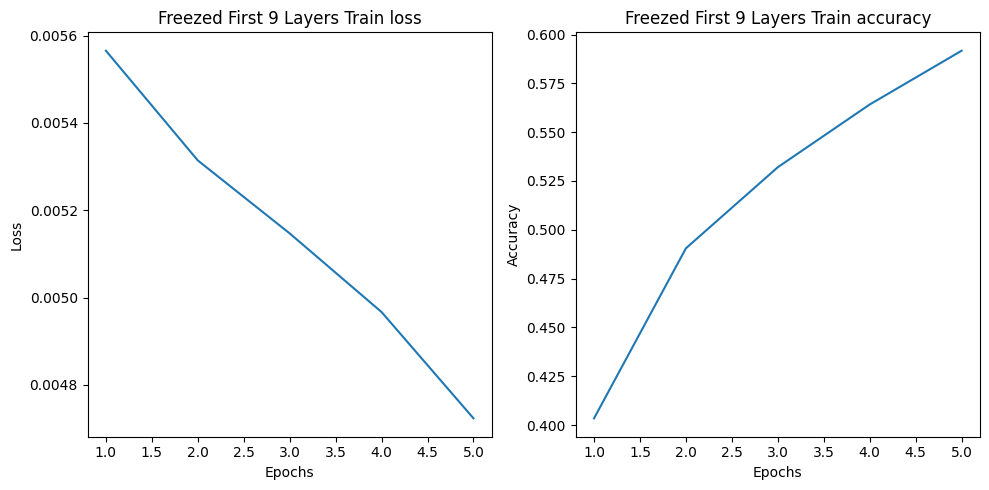

In [34]:
plot_training_summary('Freezed First 9 Layers Train', freezed_first_9_layers_train_losses, freezed_first_9_layers_train_accs, num_epochs)

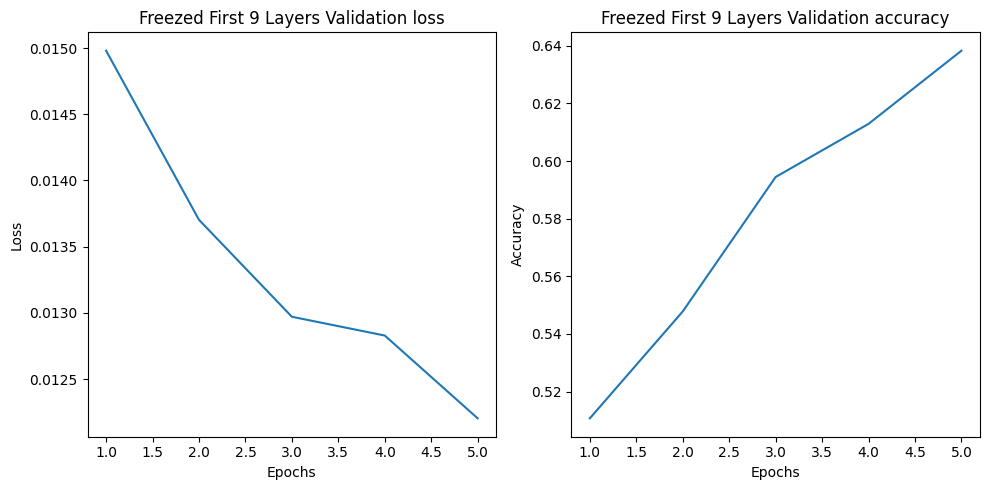

In [35]:
plot_training_summary('Freezed First 9 Layers Validation', freezed_first_9_layers_test_losses, freezed_first_9_layers_test_accs, num_epochs)

In [36]:
freezed_first_9_layers_loss, freezed_first_9_layers_acc, freezed_first_9_layers_actual_labels, freezed_first_9_layers_predictions = evaluate_classifier(model_freezed_first_9_layers, test_dataloader, criterion)

100%|██████████| 24/24 [00:10<00:00,  2.28it/s]

Loss: 0.0010 | Accuracy: 0.6240


              precision    recall  f1-score   support

           c       0.56      0.50      0.53       501
           e       0.60      0.81      0.69       510
           n       0.78      0.59      0.67       525

    accuracy                           0.64      1536
   macro avg       0.65      0.64      0.63      1536
weighted avg       0.65      0.64      0.63      1536



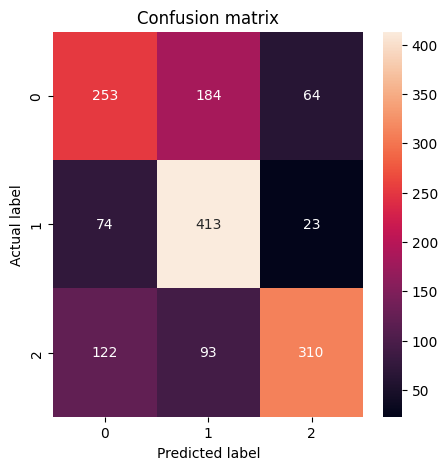

In [37]:
calculate_metrics(freezed_first_9_layers_actual_labels, freezed_first_9_layers_predictions)

### Fine-Tuning BERT With Freezing All Layers Except Embedding Layer and Last Layer

In [38]:
model_freezed_all_except_embeddings = BaseLineModel(model_name, 3)
model_freezed_all_except_embeddings.to(device)
model_freezed_all_except_embeddings

BaseLineModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [39]:
for i in range(0, 11):
    for param in model_freezed_all_except_embeddings.bert.encoder.layer[i].parameters():
        param.requires_grad = False
# for param in model_freezed_all_except_embeddings.bert.pooler.parameters():
#     param.requires_grad = False

total_params = sum(p.numel() for p in model_freezed_all_except_embeddings.parameters())
trainable_params = sum(p.numel() for p in model_freezed_all_except_embeddings.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}, Trainable parameters: {trainable_params}')

Total parameters: 162843651, Trainable parameters: 84877059


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_freezed_all_except_embeddings.parameters(), lr=2e-5)
num_epochs = 6

freezed_all_except_embeddings_train_losses, freezed_all_except_embeddings_train_accs, freezed_all_except_embeddings_test_losses, freezed_all_except_embeddings_test_accs = train_classifier(model_freezed_all_except_embeddings, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

---------- Epoch 1/6 ----------


100%|██████████| 24/24 [00:10<00:00,  2.28it/s]


Epoch 1/6:
Training loss: 0.0056 | Training accuracy: 0.6094
Testing loss: 0.0155 | Testing accuracy: 0.6517

---------- Epoch 2/6 ----------


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


Epoch 2/6:
Training loss: 0.0053 | Training accuracy: 0.6405
Testing loss: 0.0144 | Testing accuracy: 0.6784

---------- Epoch 3/6 ----------


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


Epoch 3/6:
Training loss: 0.0051 | Training accuracy: 0.6482
Testing loss: 0.0140 | Testing accuracy: 0.6701

---------- Epoch 4/6 ----------


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


Epoch 4/6:
Training loss: 0.0049 | Training accuracy: 0.6622
Testing loss: 0.0136 | Testing accuracy: 0.7025

---------- Epoch 5/6 ----------


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


Epoch 5/6:
Training loss: 0.0046 | Training accuracy: 0.6874
Testing loss: 0.0135 | Testing accuracy: 0.6929

---------- Epoch 6/6 ----------


100%|██████████| 24/24 [00:10<00:00,  2.28it/s]

Epoch 6/6:
Training loss: 0.0043 | Training accuracy: 0.7094
Testing loss: 0.0132 | Testing accuracy: 0.7011



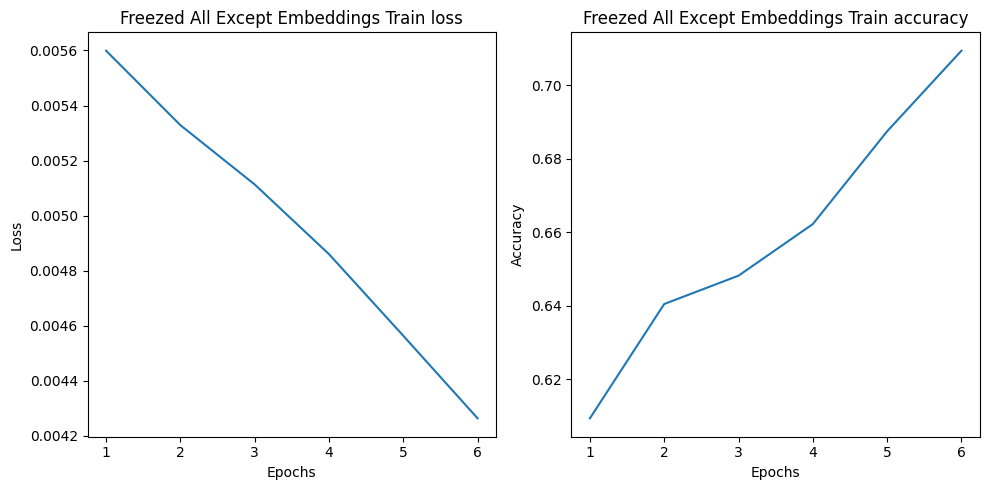

In [41]:
plot_training_summary('Freezed All Except Embeddings Train', freezed_all_except_embeddings_train_losses, freezed_all_except_embeddings_train_accs, num_epochs)

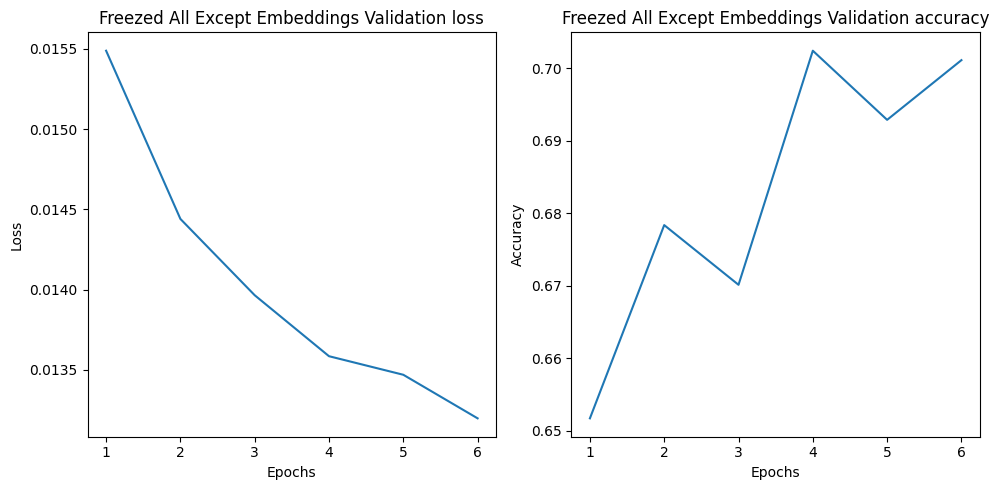

In [42]:
plot_training_summary('Freezed All Except Embeddings Validation', freezed_all_except_embeddings_test_losses, freezed_all_except_embeddings_test_accs, num_epochs)

In [43]:
freezed_all_except_embeddings_loss, freezed_all_except_embeddings_acc, freezed_all_except_embeddings_actual_labels, freezed_all_except_embeddings_predictions = evaluate_classifier(model_freezed_all_except_embeddings, test_dataloader, criterion)

100%|██████████| 24/24 [00:10<00:00,  2.28it/s]

Loss: 0.0011 | Accuracy: 0.5518


              precision    recall  f1-score   support

           c       0.45      0.41      0.43       501
           e       0.54      0.73      0.62       510
           n       0.73      0.55      0.62       525

    accuracy                           0.56      1536
   macro avg       0.57      0.56      0.56      1536
weighted avg       0.57      0.56      0.56      1536



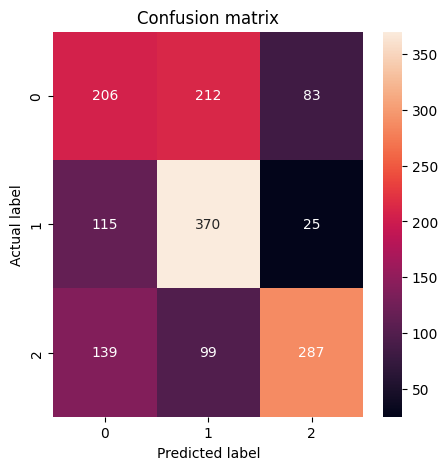

In [44]:
calculate_metrics(freezed_all_except_embeddings_actual_labels, freezed_all_except_embeddings_predictions)

### Fine-Tuning BERT By Keeping Only First 9 Layers

In [45]:
model_with_9_layered_encoder = BaseLineModel(model_name, 3, num_layers_to_keep=9)
model_with_9_layered_encoder.to(device)
model_with_9_layered_encoder

BaseLineModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-8): 9 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [46]:
total_params = sum(p.numel() for p in model_with_9_layered_encoder.parameters())
trainable_params = sum(p.numel() for p in model_with_9_layered_encoder.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}, Trainable parameters: {trainable_params}')

Total parameters: 141580035, Trainable parameters: 141580035


In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_with_9_layered_encoder.parameters(), lr=2e-5)
num_epochs = 5

model_with_9_layered_encoder_train_losses, model_with_9_layered_encoder_train_accs, model_with_9_layered_encoder_test_losses, model_with_9_layered_encoder_test_accs = train_classifier(model_with_9_layered_encoder, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

---------- Epoch 1/5 ----------


100%|██████████| 24/24 [00:07<00:00,  3.04it/s]


Epoch 1/5:
Training loss: 0.0054 | Training accuracy: 0.5486
Testing loss: 0.0132 | Testing accuracy: 0.6814

---------- Epoch 2/5 ----------


100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


Epoch 2/5:
Training loss: 0.0048 | Training accuracy: 0.6325
Testing loss: 0.0120 | Testing accuracy: 0.7391

---------- Epoch 3/5 ----------


100%|██████████| 24/24 [00:07<00:00,  3.03it/s]


Epoch 3/5:
Training loss: 0.0040 | Training accuracy: 0.7189
Testing loss: 0.0112 | Testing accuracy: 0.7456

---------- Epoch 4/5 ----------


100%|██████████| 24/24 [00:07<00:00,  3.03it/s]


Epoch 4/5:
Training loss: 0.0031 | Training accuracy: 0.7737
Testing loss: 0.0116 | Testing accuracy: 0.7525

---------- Epoch 5/5 ----------


100%|██████████| 24/24 [00:07<00:00,  3.02it/s]

Epoch 5/5:
Training loss: 0.0022 | Training accuracy: 0.8323
Testing loss: 0.0140 | Testing accuracy: 0.7235



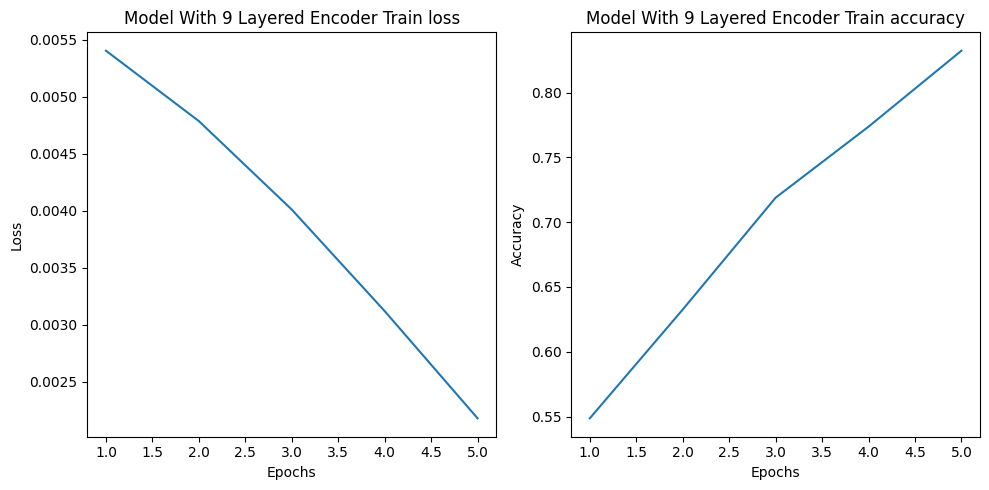

In [48]:
plot_training_summary('Model With 9 Layered Encoder Train', model_with_9_layered_encoder_train_losses, model_with_9_layered_encoder_train_accs, num_epochs)

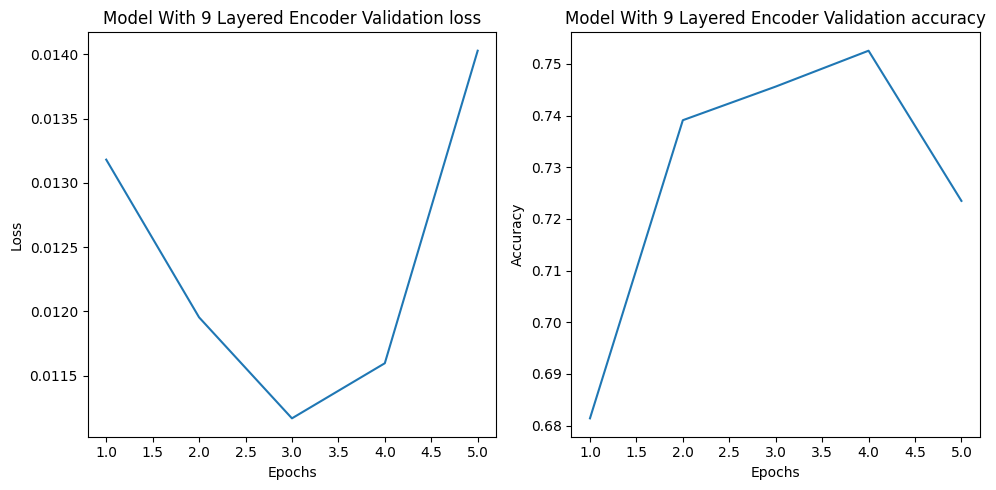

In [49]:
plot_training_summary('Model With 9 Layered Encoder Validation', model_with_9_layered_encoder_test_losses, model_with_9_layered_encoder_test_accs, num_epochs)

In [50]:
model_with_9_layered_encoder_loss, model_with_9_layered_encoder_acc, model_with_9_layered_encoder_actual_labels, model_with_9_layered_encoder_predictions = evaluate_classifier(model_with_9_layered_encoder, test_dataloader, criterion)

100%|██████████| 24/24 [00:07<00:00,  3.03it/s]

Loss: 0.0012 | Accuracy: 0.6170


              precision    recall  f1-score   support

           c       0.60      0.54      0.57       501
           e       0.68      0.61      0.64       510
           n       0.61      0.73      0.66       525

    accuracy                           0.63      1536
   macro avg       0.63      0.63      0.63      1536
weighted avg       0.63      0.63      0.63      1536



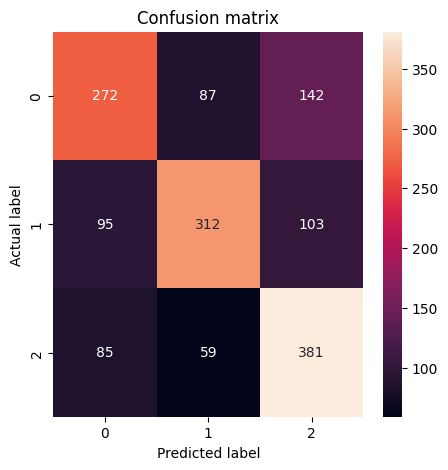

In [51]:
calculate_metrics(model_with_9_layered_encoder_actual_labels, model_with_9_layered_encoder_predictions)

### Fine-Tuning BERT After Removing Attention Heads

In [52]:
class PrunedModel(nn.Module):
    def __init__(self, model_name, num_classes, num_layers_to_keep=12, prune_heads_percent=0.0):
        super(PrunedModel, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.config.num_labels = num_classes
        self.config.num_hidden_layers = num_layers_to_keep
        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)

        self.prune_heads_dict = {}
        for i in range(num_layers_to_keep):
            num_heads = self.bert.encoder.layer[i].attention.self.num_attention_heads
            num_pruned_heads = int(num_heads * prune_heads_percent)
            pruned_heads = np.random.choice(num_heads, num_pruned_heads, replace=False)
            self.prune_heads_dict[i] = pruned_heads
        self.bert.prune_heads(self.prune_heads_dict)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [53]:
pruned_model = PrunedModel(model_name, 3, prune_heads_percent=0.5)
pruned_model.to(device)
pruned_model

PrunedModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=384, bias=True)
              (key): Linear(in_features=768, out_features=384, bias=True)
              (value): Linear(in_features=768, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [54]:
total_params = sum(p.numel() for p in pruned_model.parameters())
trainable_params = sum(p.numel() for p in pruned_model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}, Trainable parameters: {trainable_params}')

Total parameters: 148674051, Trainable parameters: 148674051


In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(pruned_model.parameters(), lr=2e-5)
num_epochs = 5

pruned_model_train_losses, pruned_model_train_accs, pruned_model_test_losses, pruned_model_test_accs = train_classifier(pruned_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

---------- Epoch 1/5 ----------


100%|██████████| 24/24 [00:08<00:00,  2.74it/s]


Epoch 1/5:
Training loss: 0.0055 | Training accuracy: 0.6016
Testing loss: 0.0135 | Testing accuracy: 0.7361

---------- Epoch 2/5 ----------


100%|██████████| 24/24 [00:08<00:00,  2.74it/s]


Epoch 2/5:
Training loss: 0.0048 | Training accuracy: 0.6663
Testing loss: 0.0134 | Testing accuracy: 0.6823

---------- Epoch 3/5 ----------


100%|██████████| 24/24 [00:08<00:00,  2.75it/s]


Epoch 3/5:
Training loss: 0.0041 | Training accuracy: 0.7262
Testing loss: 0.0127 | Testing accuracy: 0.7311

---------- Epoch 4/5 ----------


100%|██████████| 24/24 [00:08<00:00,  2.74it/s]


Epoch 4/5:
Training loss: 0.0033 | Training accuracy: 0.7829
Testing loss: 0.0130 | Testing accuracy: 0.7254

---------- Epoch 5/5 ----------


100%|██████████| 24/24 [00:08<00:00,  2.75it/s]

Epoch 5/5:
Training loss: 0.0026 | Training accuracy: 0.8243
Testing loss: 0.0147 | Testing accuracy: 0.7074



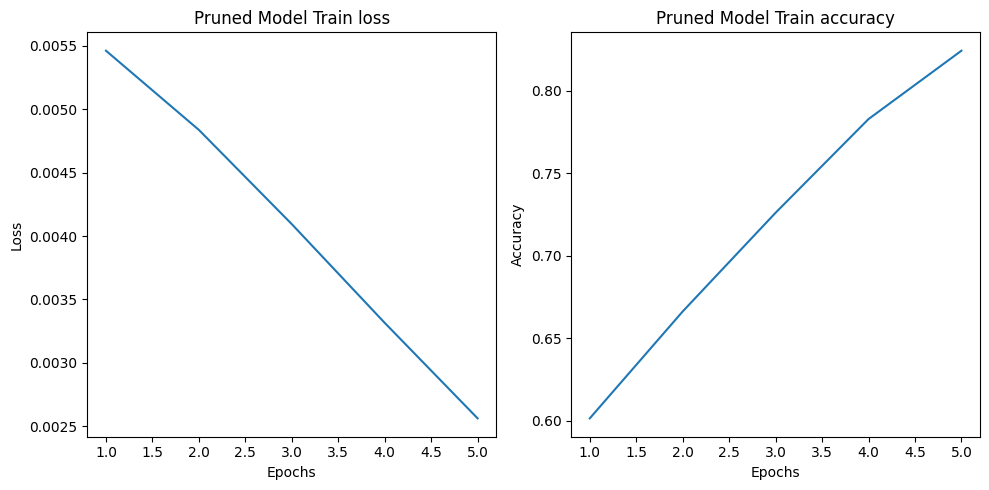

In [56]:
plot_training_summary('Pruned Model Train', pruned_model_train_losses, pruned_model_train_accs, num_epochs)

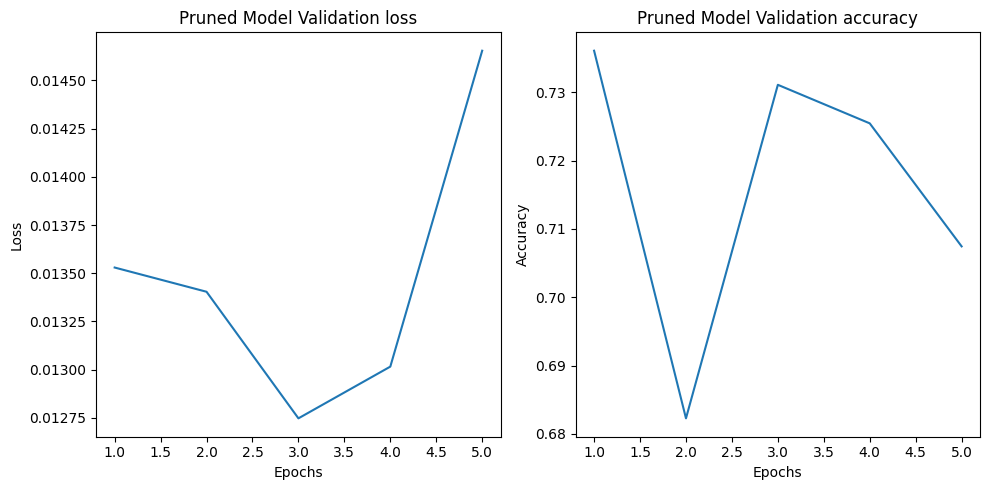

In [57]:
plot_training_summary('Pruned Model Validation', pruned_model_test_losses, pruned_model_test_accs, num_epochs)

In [58]:
pruned_model_loss, pruned_model_acc, pruned_model_actual_labels, pruned_model_predictions = evaluate_classifier(pruned_model, test_dataloader, criterion)

100%|██████████| 24/24 [00:08<00:00,  2.75it/s]

Loss: 0.0010 | Accuracy: 0.6074


              precision    recall  f1-score   support

           c       0.54      0.64      0.58       501
           e       0.63      0.67      0.65       510
           n       0.72      0.55      0.63       525

    accuracy                           0.62      1536
   macro avg       0.63      0.62      0.62      1536
weighted avg       0.63      0.62      0.62      1536



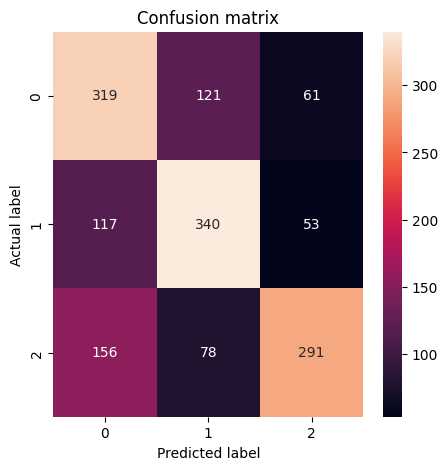

In [59]:
calculate_metrics(pruned_model_actual_labels, pruned_model_predictions)